Evaluate and test **FASTSRegressor** to make forecasts of the number of Sunspots.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from io import StringIO

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from IPython.display import HTML, display
pd.options.plotting.backend = "plotly"

import datetime
from time import time

import warnings
warnings.filterwarnings('ignore')

from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 12, 6

import sys
# sys.path.append("C:\\PROGRAMMAZIONE\\Sviluppo\\AI\\MachineLearning\\Projects\\autolrn_sk21")
sys.path.append("C:\\PROGRAMMAZIONE\\Sviluppo\\AI\\MachineLearning\\timeseries\\projects\\fasts_demo")

from fasts import estimators as es
from fasts import valid as vd
from fasts import utils as us
from fasts.datasets import load_data

from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

from sklearn.metrics import mean_squared_error

from scipy.special import boxcox, boxcox1p, inv_boxcox, inv_boxcox1p
from statsmodels.tsa.stattools import adfuller, kpss

# from sklearnex import patch_sklearn
# patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
sunspots = load_data("sunspots.csv", dataframe=True)
sunspots_y = sunspots.resample('Y', on="Month").mean()

In [3]:
display(sunspots_y.Sunspots)

Month
1749-12-31     80.925000
1750-12-31     83.391667
1751-12-31     47.658333
1752-12-31     47.800000
1753-12-31     30.691667
                 ...    
1979-12-31    155.275000
1980-12-31    154.650000
1981-12-31    140.375000
1982-12-31    116.291667
1983-12-31     66.633333
Freq: A-DEC, Name: Sunspots, Length: 235, dtype: float64

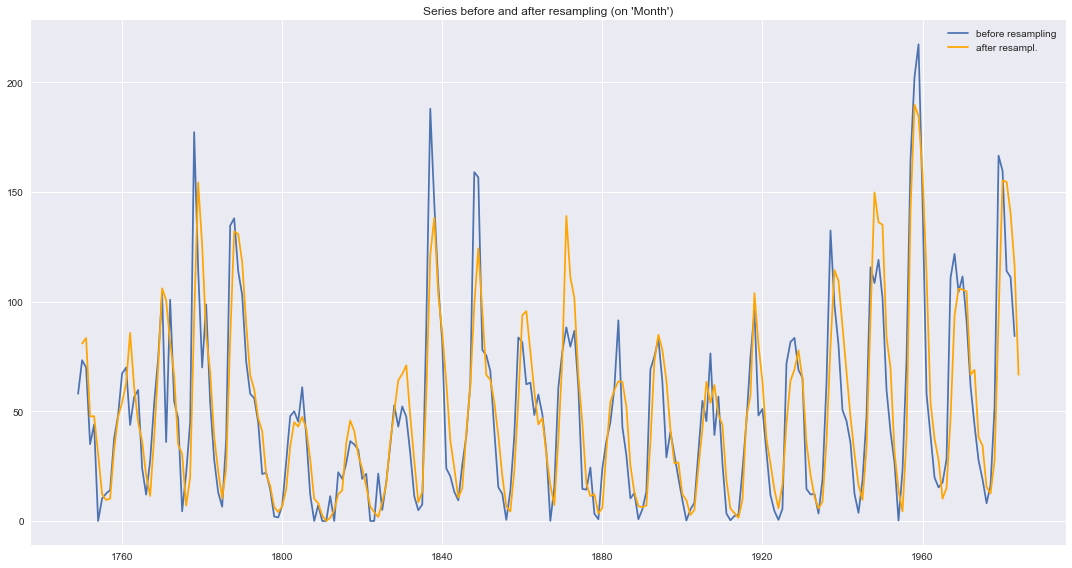

In [4]:
plt.figure(figsize=(15, 8))
plt.plot(sunspots.set_index("Month").Sunspots[::12], label="before resampling")
plt.plot(sunspots_y, label="after resampl.", color="orange")
plt.title("Series before and after resampling (on 'Month')")
plt.legend()    
plt.tight_layout()

In [5]:
n_jobs=-1
# 5, 10, 15, 25, 50, 75
n_iter=25
# forecasting horizon: 
# monthly: 5 years == 60 months, 3 years == 36 months
# yearly: 10,11, 20, 22, 24 -- two years
fh=24
test_size=fh
n_lags=11

In [6]:
sunspots_y.min()

Sunspots    0.0
dtype: float64

## Power Transformations

### Sklearn's MinMax scaler + PowerTransform

In [7]:
# perform a box-cox transform of the dataset
scaler = MinMaxScaler(feature_range=(1, 10))
# method='box-cox'
power = PowerTransformer(standardize=False, method='box-cox')
pipeline = Pipeline(steps=[('s', scaler),('p', power)])

In [8]:
sunspots_y_scale_bc = pipeline.fit_transform(sunspots_y.Sunspots.values.reshape(-1, 1)).ravel()
sunspots_y_scale_bc[:10]

array([1.57499046, 1.59884566, 1.18085369, 1.18290981, 0.8977345 ,
       0.45678352, 0.37391989, 0.39409178, 0.93062935, 1.18000582])

In [9]:
len(sunspots_y_scale_bc)

235

In [10]:
X, y = us.embed_to_X_y(
    pd.Series(sunspots_y_scale_bc), 
    n_lags=n_lags, name='sunspots')

In [11]:
y.min()

0.0

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, shuffle=False)

In [13]:
display(X_train)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
0,1.268538,1.180006,0.930629,0.394092,0.373920,0.456784,0.897735,1.182910,1.180854,1.598846,1.574990
1,1.380351,1.268538,1.180006,0.930629,0.394092,0.373920,0.456784,0.897735,1.182910,1.180854,1.598846
2,1.622066,1.380351,1.268538,1.180006,0.930629,0.394092,0.373920,0.456784,0.897735,1.182910,1.180854
3,1.359819,1.622066,1.380351,1.268538,1.180006,0.930629,0.394092,0.373920,0.456784,0.897735,1.182910
4,1.143226,1.359819,1.622066,1.380351,1.268538,1.180006,0.930629,0.394092,0.373920,0.456784,0.897735
...,...,...,...,...,...,...,...,...,...,...,...
195,0.189761,0.504630,0.911467,1.459232,1.603929,2.000322,2.007220,2.090231,1.682371,0.942998,0.374735
196,1.028785,0.189761,0.504630,0.911467,1.459232,1.603929,2.000322,2.007220,2.090231,1.682371,0.942998
197,2.041575,1.028785,0.189761,0.504630,0.911467,1.459232,1.603929,2.000322,2.007220,2.090231,1.682371
198,2.300103,2.041575,1.028785,0.189761,0.504630,0.911467,1.459232,1.603929,2.000322,2.007220,2.090231


In [14]:
y_train.min()

0.0

In [15]:
fasts = es.FASTSRegressor(
    # lasso_alpha=0.01,
    quantile_reg=True,
    )
fasts_params = vd.fasts_param_distros

In [16]:
fasts_params

{'lasso_alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x26b5937c548>,
 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen at 0x26b5937cc48>,
 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen at 0x26b5937cf88>,
 'subsample': <scipy.stats._distn_infrastructure.rv_frozen at 0x26b5937c408>,
 'max_features': [None, 0.75, 0.5, 'log2'],
 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen at 0x26b59380908>,
 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen at 0x26b59380e48>}

In [17]:
display(X_train.head(3))

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
0,1.268538,1.180006,0.930629,0.394092,0.373920,0.456784,0.897735,1.182910,1.180854,1.598846,1.574990
1,1.380351,1.268538,1.180006,0.930629,0.394092,0.373920,0.456784,0.897735,1.182910,1.180854,1.598846
2,1.622066,1.380351,1.268538,1.180006,0.930629,0.394092,0.373920,0.456784,0.897735,1.182910,1.180854


In [18]:
# %time fasts.fit(X_train, y_train)

In [19]:
print("=== TS Randomized Search CV...")
print()

rscv = vd.TSRandomizedSearchCV(
    estimator=fasts, n_split=3, param_distro=fasts_params, fh=fh, 
    test_size=test_size, n_iter=n_iter, 
    n_jobs=n_jobs
)

failed = 0
try:
    t0 = time()
    rscv.fit(X_train, y_train)
    t1 = time()
except ValueError as ve:
    failed = 1
    print("ValueError:", ve)
    # adjust learning_rate distro for spanning little numbers?
    fasts_params["lasso_alpha"] = vd.loguniform(1e-3, 1e-1)
except Exception as e:
    failed = 1
    print("Mysterious Exception:", e)

=== TS Randomized Search CV...

ValueError: Found array with 0 feature(s).


In [20]:
if failed:
    try:
        t0 = time()
        rscv.fit(X_train, y_train)
        t1 = time()
    except ValueError as ve:
        print("ValueError:", ve)
    except Exception as e:
        print("Mysterious Exception:", e)

Best validation rmse score overall: 0.387 ± 0.101
Refitting best estimator...
X cols 11
X_sel_ cols 6
with quantile regression.
self.gbr_fitted_.n_features = 6


Full time of Search: 91.85 s

=== Compare best estimator to baselines on test data...

FASTSRegressor with quantile regression performed.

=== Trying to make forecasts w FASTSRegressor...



test windows:
[2.140932359795372, 2.274913606028756, 2.300103029210171, 2.04157466309169, 1.0287845864475293, 0.1897607976729972, 0.5046304517642459, 0.9114669446318319, 1.4592321819812848, 1.6039293856007204, 2.0003217789023653]
length of first Lasso test window: 11
[0.10503550203571299, -0.023499360580851114, -0.07171979553718266, 0.5425412171975288, 0.6086129831193683, -0.23391053018658509]
length of first GradBoost test window (residuals): 6

... gonna predict quantiles as well.

length of first vanilla GradBoost test window before quant. reg: 11
[0.10503550203571299, -0.023499360580851114, -0.07171979553718266, 0.5425412171975288, 0.6086129831193683, -0.23391053018658509]
length of first GradBoost quantile test window (0.95): 6


You're here: 'lasso' loop...

You're here: 'grad_boost' loop...


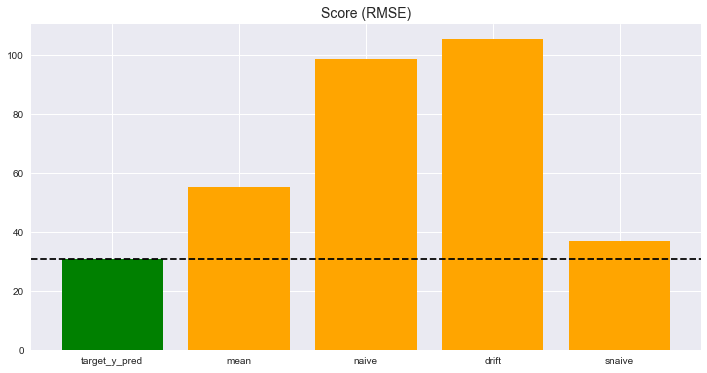

In [21]:
print(f"Full time of Search: {(t1 - t0):.2f} s")
print()

best_fasts = rscv.best_params_['best_estimator']

print("=== Compare best estimator to baselines on test data...")

scores, spreds, tgt_preds = best_fasts.compare_to_baselines(
    y_train, 
    y_test, 
    season=11,
    fh=fh, 
    bar_plot=True,
    bck_transformer=pipeline,
    prune=True
)

In [22]:
sunspots_y.Sunspots.values

array([ 80.925     ,  83.39166667,  47.65833333,  47.8       ,
        30.69166667,  12.21666667,   9.56666667,  10.19166667,
        32.425     ,  47.6       ,  53.96666667,  62.85833333,
        85.85      ,  61.15      ,  45.11666667,  36.35      ,
        20.90833333,  11.40833333,  37.825     ,  69.84166667,
       106.09166667, 100.8       ,  81.58333333,  66.49166667,
        34.775     ,  30.61666667,   7.00833333,  19.81666667,
        92.5       , 154.36666667, 125.925     ,  84.8       ,
        68.09166667,  38.45833333,  22.8       ,  10.16666667,
        24.1       ,  82.86666667, 132.025     , 130.90833333,
       118.10833333,  89.89166667,  66.58333333,  60.04166667,
        46.9       ,  41.        ,  21.26666667,  16.01666667,
         6.39166667,   4.06666667,   6.75833333,  14.475     ,
        34.        ,  45.03333333,  43.05      ,  47.46666667,
        42.24166667,  28.10833333,  10.05      ,   8.14166667,
         2.53333333,   0.        ,   1.41666667,   4.95

In [23]:
us.mean_absolute_percentage_error(
    sunspots_y.Sunspots.values[-fh:],
    tgt_preds[tgt_preds > 0].fillna(0)["y_pred"])

36.71408984919077

In [24]:
tgt_preds

,y_pred,low_80,up_80,low_95,up_95
0,109.149478,21.664813,376.088078,2.578660,697.435117
1,64.694547,-0.067650,329.573157,-11.124616,720.325605
2,34.872539,-5.567046,180.944391,-13.232085,378.740979
3,17.741822,-10.851656,126.401634,-16.045342,278.792583
4,14.651081,-10.345833,97.941808,-15.414448,204.575926
5,25.499488,-5.996556,122.871515,-12.793538,241.174069
6,49.849611,-1.390609,234.734613,-11.111627,484.901010
7,83.390538,10.794708,321.703756,-4.109510,623.652351
8,112.592212,21.359841,400.398762,1.998972,755.053826
9,119.567056,24.453922,413.811768,3.939464,771.472973


In [25]:
spreds

,mean,naive,drift,snaive
0,39.204675,158.75,158.582062,135.116667
1,39.204675,158.75,158.582062,83.925000
2,39.204675,158.75,160.391495,69.758333
3,39.204675,158.75,160.391495,31.408333
4,39.204675,158.75,162.219168,13.850000
5,39.204675,158.75,162.219168,4.408333
6,39.204675,158.75,162.219168,37.950000
7,39.204675,158.75,164.065264,141.708333
8,39.204675,158.75,164.065264,189.850000
9,39.204675,158.75,165.929970,184.591667


In [26]:
sunspots_y["Sunspots"][-fh:]

Month
1960-12-31    112.275000
1961-12-31     53.900000
1962-12-31     37.600000
1963-12-31     27.891667
1964-12-31     10.200000
1965-12-31     15.058333
1966-12-31     46.875000
1967-12-31     93.666667
1968-12-31    105.891667
1969-12-31    105.558333
1970-12-31    104.691667
1971-12-31     66.650000
1972-12-31     68.933333
1973-12-31     38.150000
1974-12-31     34.408333
1975-12-31     15.458333
1976-12-31     12.550000
1977-12-31     27.483333
1978-12-31     92.658333
1979-12-31    155.275000
1980-12-31    154.650000
1981-12-31    140.375000
1982-12-31    116.291667
1983-12-31     66.633333
Freq: A-DEC, Name: Sunspots, dtype: float64


full_time_series_df
            orig_scale_posts  forecasts      y_test       mean   naive  \
Month                                                                    
1979-12-31               NaN  84.434278  155.275000  39.204675  158.75   
1980-12-31               NaN  84.640047  154.650000  39.204675  158.75   
1981-12-31               NaN  71.130086  140.375000  39.204675  158.75   
1982-12-31               NaN  52.425490  116.291667  39.204675  158.75   
1983-12-31               NaN  36.762919   66.633333  39.204675  158.75   

                 drift      snaive     low_80       up_80  low_95       up_95  
Month                                                                          
1979-12-31  171.637626  189.850000  11.352610  322.568501     0.0  622.731436  
1980-12-31  173.578665  184.591667   8.633294  355.546393     0.0  719.006658  
1981-12-31  173.578665  158.750000   6.712421  285.191073     0.0  558.728105  
1982-12-31  175.539270  135.116667   2.519993  208.075691   

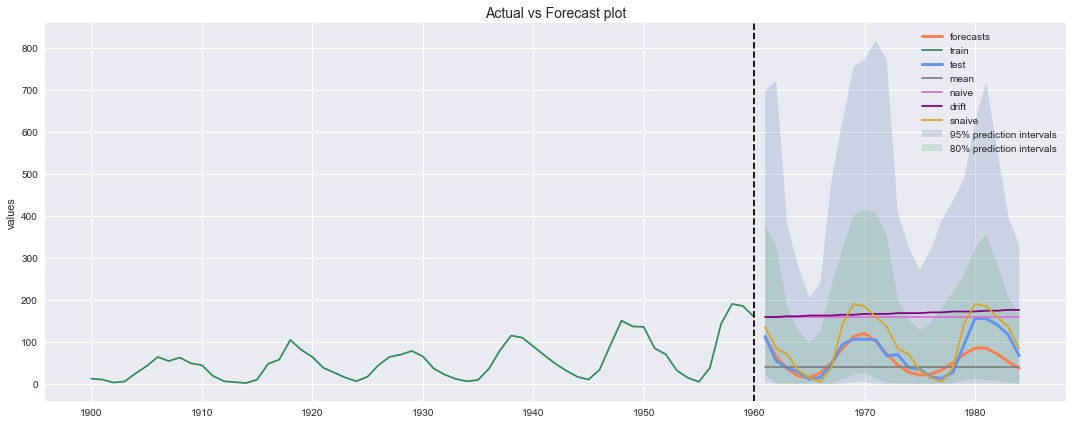

In [27]:
us.plot_forecasts(
    sunspots_y["Sunspots"][150:-fh],
    tgt_preds[tgt_preds > 0].fillna(0),
    sunspots_y.index[150:], 
    y_test=sunspots_y["Sunspots"][-fh:],
    simple_preds=spreds,
    return_pred_int=True)

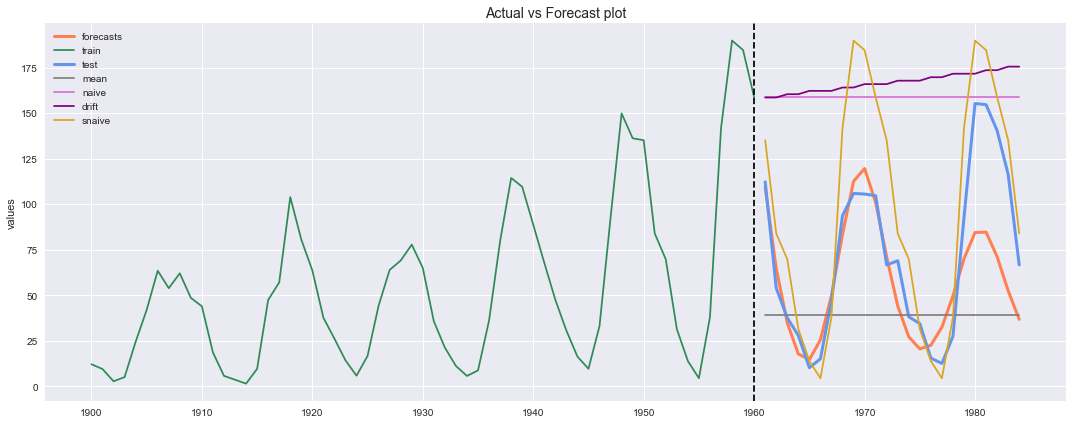

In [28]:
us.plot_forecasts(
    sunspots_y["Sunspots"][150:-fh],
    tgt_preds[tgt_preds > 0].fillna(0),
    sunspots_y.index[150:], 
    y_test=sunspots_y["Sunspots"][-fh:],
    simple_preds=spreds)

Overperform baselines but **totally misses** the point on test data. Model fails to get the second peak and to forecast next solar cycle lenghts.

In [29]:
fasts.get_params()

{'criterion': 'friedman_mse',
 'lasso_alpha': 0.006113597569316244,
 'learning_rate': 0.4274638817460995,
 'loss': 'quantile',
 'max_depth': 5,
 'max_features': 0.75,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 32,
 'quantile_reg': True,
 'subsample': 0.716551143998537}

### log 2 exp

In [30]:
sunspots_y_log = np.log1p(sunspots_y.Sunspots.values)
sunspots_y_log[:10]

array([4.40580419, 4.43546866, 3.88482309, 3.88773031, 3.45605377,
       2.58147866, 2.35770439, 2.41516945, 3.50930412, 3.88362353])

In [31]:
np.expm1(sunspots_y_log)

array([ 80.925     ,  83.39166667,  47.65833333,  47.8       ,
        30.69166667,  12.21666667,   9.56666667,  10.19166667,
        32.425     ,  47.6       ,  53.96666667,  62.85833333,
        85.85      ,  61.15      ,  45.11666667,  36.35      ,
        20.90833333,  11.40833333,  37.825     ,  69.84166667,
       106.09166667, 100.8       ,  81.58333333,  66.49166667,
        34.775     ,  30.61666667,   7.00833333,  19.81666667,
        92.5       , 154.36666667, 125.925     ,  84.8       ,
        68.09166667,  38.45833333,  22.8       ,  10.16666667,
        24.1       ,  82.86666667, 132.025     , 130.90833333,
       118.10833333,  89.89166667,  66.58333333,  60.04166667,
        46.9       ,  41.        ,  21.26666667,  16.01666667,
         6.39166667,   4.06666667,   6.75833333,  14.475     ,
        34.        ,  45.03333333,  43.05      ,  47.46666667,
        42.24166667,  28.10833333,  10.05      ,   8.14166667,
         2.53333333,   0.        ,   1.41666667,   4.95

In [32]:
X_log, y_log = us.embed_to_X_y(
    pd.Series(sunspots_y_log), 
    n_lags=n_lags, name='log_sunspots')

display(X_log)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
0,4.006727,3.883624,3.509304,2.415169,2.357704,2.581479,3.456054,3.887730,3.884823,4.435469,4.405804
1,4.156667,4.006727,3.883624,3.509304,2.415169,2.357704,2.581479,3.456054,3.887730,3.884823,4.435469
2,4.464182,4.156667,4.006727,3.883624,3.509304,2.415169,2.357704,2.581479,3.456054,3.887730,3.884823
3,4.129551,4.464182,4.156667,4.006727,3.883624,3.509304,2.415169,2.357704,2.581479,3.456054,3.887730
4,3.831174,4.129551,4.464182,4.156667,4.006727,3.883624,3.509304,2.415169,2.357704,2.581479,3.456054
...,...,...,...,...,...,...,...,...,...,...,...
219,4.539653,3.349319,2.606387,2.800832,3.566947,3.667400,4.247542,4.214347,4.660526,4.668693,4.671816
220,5.051617,4.539653,3.349319,2.606387,2.800832,3.566947,3.667400,4.247542,4.214347,4.660526,4.668693
221,5.047610,5.051617,4.539653,3.349319,2.606387,2.800832,3.566947,3.667400,4.247542,4.214347,4.660526
222,4.951416,5.047610,5.051617,4.539653,3.349319,2.606387,2.800832,3.566947,3.667400,4.247542,4.214347


In [33]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_log, test_size=test_size, random_state=42, shuffle=False)

In [34]:
fasts_log = es.FASTSRegressor(
    quantile_reg=True,
    )

In [35]:
print("=== TS Randomized Search CV...")
print()

rscv_log = vd.TSRandomizedSearchCV(
    estimator=fasts_log, n_split=3, param_distro=fasts_params, fh=fh, 
    test_size=test_size, n_iter=n_iter, 
    n_jobs=n_jobs
)

t0 = time()
rscv_log.fit(X_train_log, y_train_log)
t1 = time()

=== TS Randomized Search CV...

Best validation rmse score overall: 0.712 ± 0.123
Refitting best estimator...
X cols 11
X_sel_ cols 10
with quantile regression.
self.gbr_fitted_.n_features = 10


Full time of Search: 50.82 s

=== Compare best estimator to baselines on test data...

FASTSRegressor with quantile regression performed.

=== Trying to make forecasts w FASTSRegressor...



test windows:
[5.073610093257644, 5.223548919918803, 5.251487779191239, 4.96080292034838, 3.6622787723167574, 1.687940973922044, 2.6979998652487085, 3.478415591373701, 4.259270315217318, 4.441768514046648, 4.913512361136175]
length of first Lasso test window: 11
[0.08123492020784528, 0.08600214715093557, -0.016024764823296067, 0.2944387723113664, 1.7241760858829722, -0.7808263962026862, -0.14280031164116158, -0.3914727222486323, 0.29405984771669713, -0.1548617208767391]
length of first GradBoost test window (residuals): 10

... gonna predict quantiles as well.

length of first vanilla GradBoost test window before quant. reg: 11
[0.08123492020784528, 0.08600214715093557, -0.016024764823296067, 0.2944387723113664, 1.7241760858829722, -0.7808263962026862, -0.14280031164116158, -0.3914727222486323, 0.2

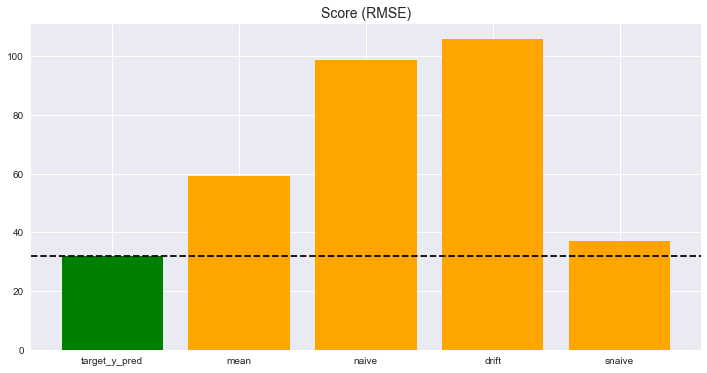

In [36]:
print(f"Full time of Search: {(t1 - t0):.2f} s")
print()

best_fasts_log = rscv_log.best_params_['best_estimator']

print("=== Compare best estimator to baselines on test data...")

scores_log, spreds_log, tgt_preds_log = best_fasts_log.compare_to_baselines(
    y_train_log, 
    y_test_log, 
    season=11,
    fh=fh, 
    bar_plot=True,
    bck_transformer=np.expm1,
    prune=True
)

In [37]:
tgt_preds_log

,y_pred,low_80,up_80,low_95,up_95
0,115.936741,6.304110,1871.124346,0.673934,8167.899156
1,67.608645,5.621177,709.922921,0.911968,2460.937188
2,42.709090,2.273421,582.635528,-0.173881,2311.601276
3,18.636927,1.531672,151.313927,-0.147347,451.245996
4,12.543514,0.122540,162.403333,-0.701022,612.512593
5,15.991499,-0.014022,291.816828,-0.782705,1327.662204
6,30.616850,1.301948,433.251886,-0.427696,1745.667527
7,59.195290,4.398996,670.138287,0.499553,2415.369323
8,94.970841,6.517425,1224.207020,0.942985,4739.337432
9,120.067229,10.244122,1302.549927,2.181426,4606.139488


In [38]:
us.mean_absolute_percentage_error(
    sunspots_y.Sunspots.values[-fh:],
    tgt_preds_log[tgt_preds_log > 0].fillna(0)["y_pred"])

26.740988537266187

**Better**.


full_time_series_df
            orig_scale_posts  forecasts      y_test       mean   naive  \
Month                                                                    
1979-12-31               NaN  66.300573  155.275000  32.540137  158.75   
1980-12-31               NaN  83.084476  154.650000  32.540137  158.75   
1981-12-31               NaN  83.646382  140.375000  32.540137  158.75   
1982-12-31               NaN  67.965534  116.291667  32.540137  158.75   
1983-12-31               NaN  47.001755   66.633333  32.540137  158.75   

                 drift      snaive    low_80        up_80    low_95  \
Month                                                                 
1979-12-31  173.164456  189.850000  4.339099   847.339154  0.389314   
1980-12-31  174.914837  184.591667  7.169759   864.411030  1.367637   
1981-12-31  174.914837  158.750000  6.022424  1019.304426  0.871291   
1982-12-31  174.914837  135.116667  5.258893   758.917898  0.749297   
1983-12-31  176.682811   83.925000

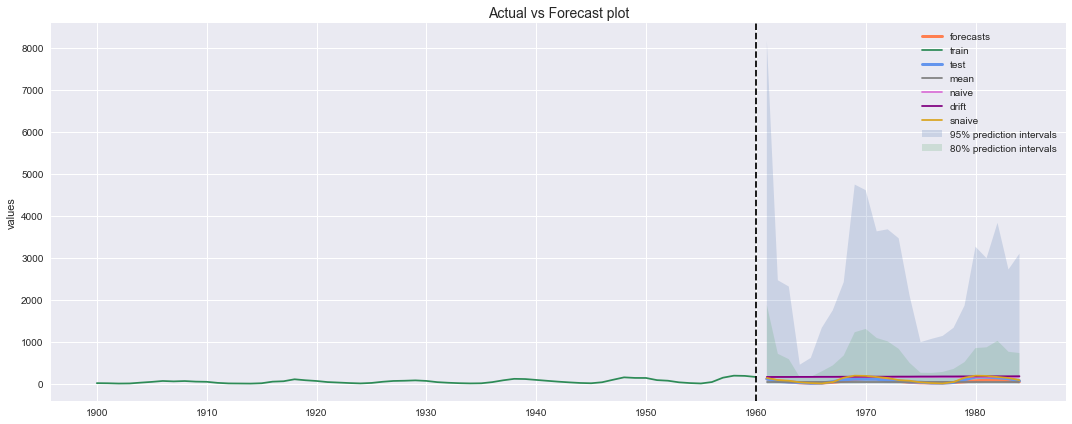

In [39]:
us.plot_forecasts(
    sunspots_y["Sunspots"][150:-fh],
    tgt_preds_log[tgt_preds_log > 0].fillna(0),
    sunspots_y.index[150:], 
    y_test=sunspots_y["Sunspots"][-fh:],
    simple_preds=spreds_log,
    return_pred_int=True)

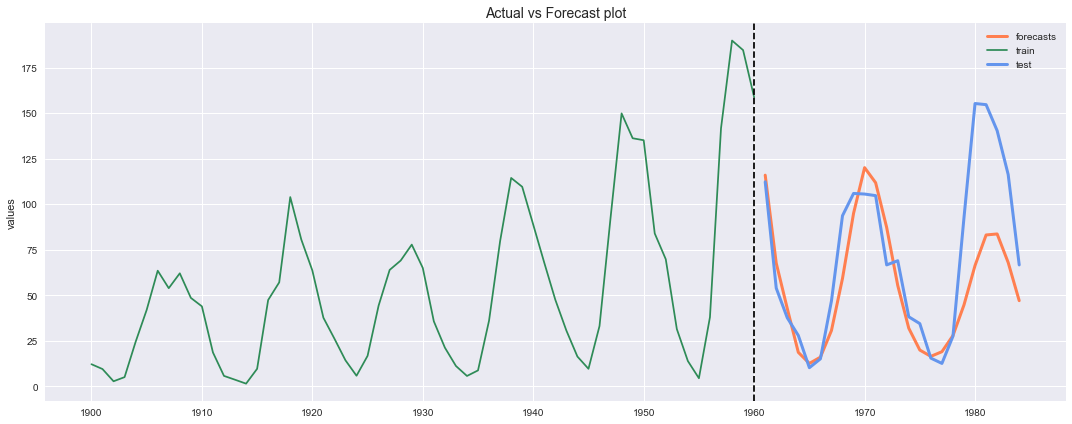

In [40]:
us.plot_forecasts(
    sunspots_y["Sunspots"][150:-fh],
    tgt_preds_log[tgt_preds_log > 0].fillna(0),
    sunspots_y.index[150:], 
    y_test=sunspots_y["Sunspots"][-fh:])

Did better than on power transformed data, but still fails to correctly model the second peak. At least matches the **solar cycles**.

##### Check

In [41]:
# no cross-val.
fasts_log_1 = es.FASTSRegressor(
    lasso_alpha=0.01,
    quantile_reg=True,
    )

In [42]:
%time fasts_log_1.fit(X_train_log, y_train_log)

X cols 11
X_sel_ cols 9
with quantile regression.
self.gbr_fitted_.n_features = 9
Wall time: 168 ms


FASTSRegressor(lasso_alpha=0.01, loss='quantile', quantile_reg=True)

In [43]:
# you can prune extreme paths directly in .predict()
tgt_preds_log_1 = fasts_log_1.predict(fh, pred_int=True, prune=True)
tgt_preds_log_1


=== Trying to make forecasts w FASTSRegressor...



test windows:
[5.073610093257644, 5.223548919918803, 5.251487779191239, 4.96080292034838, 3.6622787723167574, 1.687940973922044, 2.6979998652487085, 3.478415591373701, 4.259270315217318, 4.441768514046648, 4.913512361136175]
length of first Lasso test window: 11
[0.06840981036803129, 0.05985309641808989, -0.01594605936967497, 0.4349920160353413, 1.669424908532255, -0.8143930153638481, -0.23134858587850315, -0.33020006565906757, 0.27565433850988885]
length of first GradBoost test window (residuals): 9

... gonna predict quantiles as well.

length of first vanilla GradBoost test window before quant. reg: 11
[0.06840981036803129, 0.05985309641808989, -0.01594605936967497, 0.4349920160353413, 1.669424908532255, -0.8143930153638481, -0.23134858587850315, -0.33020006565906757, 0.27565433850988885]
length of first GradBoost quantile test window (0.95): 9


You're here: 'lasso' loop...

You're here: 'grad_boost' loop...

You're here: 'grad_b

,y_pred,low_80,up_80,low_95,up_95
0,4.733042,0.918303,8.547781,-1.108277,10.574362
1,4.244480,0.627783,7.861177,-1.293587,9.782547
2,3.690953,-0.259758,7.641664,-2.358573,9.740480
3,3.015703,-0.553062,6.584467,-2.448968,8.480373
4,2.692029,-1.311398,6.695456,-3.438219,8.822276
5,2.918388,-0.806776,6.643551,-2.785769,8.622544
6,3.504660,-0.210083,7.219403,-2.183541,9.192861
7,4.117404,0.506450,7.728358,-1.411869,9.646678
8,4.559136,0.907615,8.210657,-1.032256,10.150528
9,4.755797,1.139457,8.372137,-0.781724,10.293318


In [44]:
tgt_preds_2 = np.expm1(tgt_preds_log_1)
tgt_preds_2

,y_pred,low_80,up_80,low_95,up_95
0,112.640758,1.505036,5154.304366,-0.669873,39117.924997
1,68.719494,0.873452,2593.572401,-0.725715,17720.738139
2,39.083035,-0.228762,2082.208329,-0.905445,16990.692308
3,19.403419,-0.424814,722.764951,-0.913617,4818.245493
4,13.761594,-0.730557,807.722499,-0.967878,6782.689876
5,17.511415,-0.553705,766.816778,-0.938318,5554.503218
6,32.270130,-0.189483,1364.673762,-0.887358,9825.720179
7,60.399663,0.659391,2270.869287,-0.756313,15469.302670
8,94.500911,1.478403,3678.959495,-0.643798,25603.609656
9,115.256297,2.125071,4323.870550,-0.542384,29533.615504


In [45]:
us.mean_absolute_percentage_error(
    sunspots_y.values[-fh:],
    tgt_preds_2[tgt_preds_2 > 0].fillna(0)["y_pred"])

28.4189037441322


full_time_series_df
            orig_scale_posts  forecasts      y_test    low_80        up_80  \
Month                                                                        
1979-12-31               NaN  65.875137  155.275000  0.718267  2601.787852   
1980-12-31               NaN  79.494091  154.650000  1.306802  2807.779436   
1981-12-31               NaN  78.067341  140.375000  1.003517  3119.335446   
1982-12-31               NaN  63.102762  116.291667  0.730567  2373.461585   
1983-12-31               NaN  44.762733   66.633333  0.000000  2139.751308   

            low_95         up_95  
Month                             
1979-12-31     0.0  18205.176685  
1980-12-31     0.0  18538.819745  
1981-12-31     0.0  21986.949955  
1982-12-31     0.0  16177.224647  
1983-12-31     0.0  16510.348520  


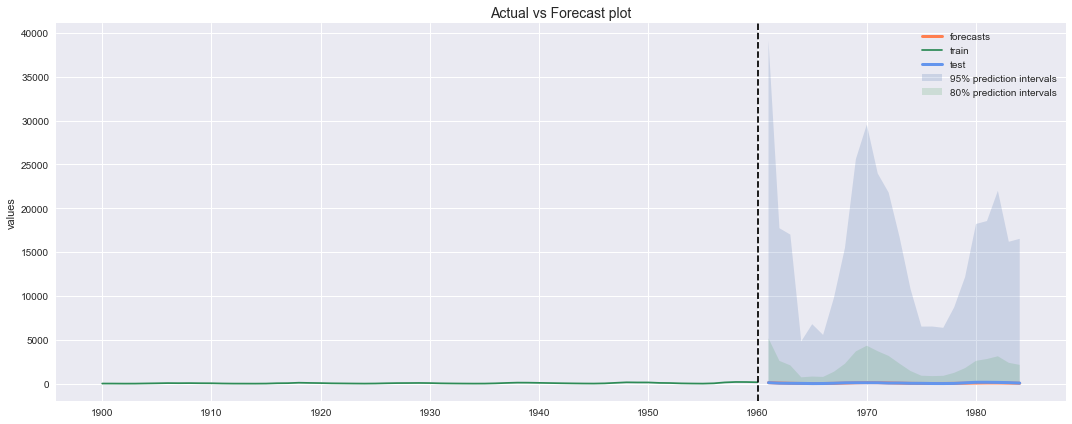

In [46]:
us.plot_forecasts(
    sunspots_y["Sunspots"][150:-fh],
    tgt_preds_2[tgt_preds_2 > 0].fillna(0),
    sunspots_y.index[150:], 
    y_test=sunspots_y["Sunspots"][-fh:],
    return_pred_int=True)

Ouch! Forecast intervals **exploded** despite pruning extreme paths!

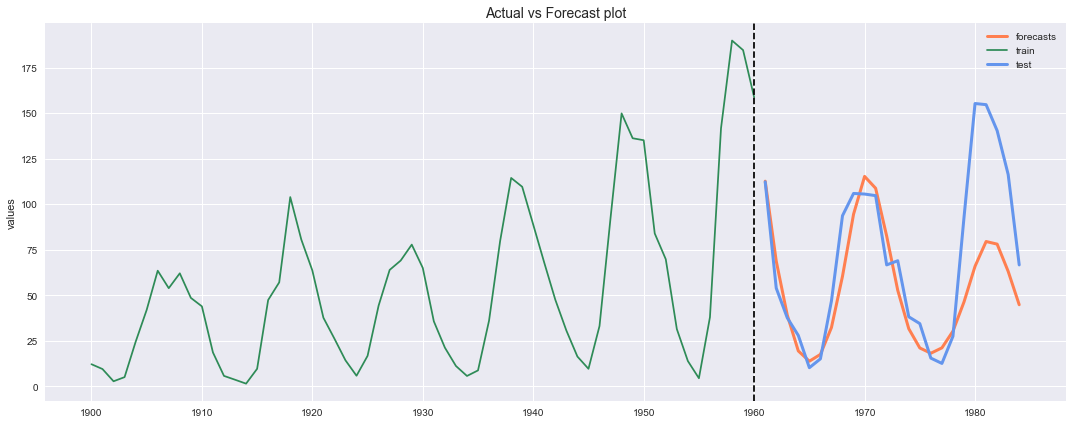

In [47]:
us.plot_forecasts(
    sunspots_y["Sunspots"][150:-fh],
    tgt_preds_2[tgt_preds_2 > 0].fillna(0),
    sunspots_y.index[150:], 
    y_test=sunspots_y["Sunspots"][-fh:])

### MinMax scaling

In [48]:
sunspots_y_scale = scaler.fit_transform(sunspots_y.Sunspots.values.reshape(-1, 1)).ravel()
sunspots_y_scale[:10]

array([4.83631815, 4.95325257, 3.25928364, 3.26599947, 2.45496445,
       1.57914143, 1.45351593, 1.48314459, 2.53713458, 3.2565183 ])

In [49]:
X_sc, y_sc = us.embed_to_X_y(
    pd.Series(sunspots_y_scale), 
    n_lags=n_lags, name='sscaled_sunspots')

In [50]:
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(
    X_sc, y_sc, test_size=test_size, random_state=42, shuffle=False)

In [51]:
display(X_train_sc)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
0,3.558336,3.256518,2.537135,1.483145,1.453516,1.579141,2.454964,3.265999,3.259284,4.953253,4.836318
1,3.979853,3.558336,3.256518,2.537135,1.483145,1.453516,1.579141,2.454964,3.265999,3.259284,4.953253
2,5.069792,3.979853,3.558336,3.256518,2.537135,1.483145,1.453516,1.579141,2.454964,3.265999,3.259284
3,3.898868,5.069792,3.979853,3.558336,3.256518,2.537135,1.483145,1.453516,1.579141,2.454964,3.265999
4,3.138794,3.898868,5.069792,3.979853,3.558336,3.256518,2.537135,1.483145,1.453516,1.579141,2.454964
...,...,...,...,...,...,...,...,...,...,...,...
195,1.208981,1.656571,2.488939,4.306953,4.978536,7.405320,7.456676,8.103371,5.385436,2.568738,1.454701
196,2.799052,1.208981,1.656571,2.488939,4.306953,4.978536,7.405320,7.456676,8.103371,5.385436,2.568738
197,7.717804,2.799052,1.208981,1.656571,2.488939,4.306953,4.978536,7.405320,7.456676,8.103371,5.385436
198,10.000000,7.717804,2.799052,1.208981,1.656571,2.488939,4.306953,4.978536,7.405320,7.456676,8.103371


In [52]:
fasts_sc = es.FASTSRegressor(
    quantile_reg=True,
    )

print("=== TS Randomized Search CV...")
print()

rscv_sc = vd.TSRandomizedSearchCV(
    estimator=fasts_sc, n_split=3, param_distro=fasts_params, fh=fh, 
    test_size=test_size, n_iter=n_iter, 
    n_jobs=n_jobs
)

t0 = time()
rscv_sc.fit(X_train_sc, y_train_sc)
t1 = time()

=== TS Randomized Search CV...

Best validation rmse score overall: 1.381 ± 0.665
Refitting best estimator...
X cols 11
X_sel_ cols 11
with quantile regression.
self.gbr_fitted_.n_features = 11


Full time of Search: 52.73 s

=== Compare best estimator to baselines on test data...

FASTSRegressor with quantile regression performed.

=== Trying to make forecasts w FASTSRegressor...



test windows:
[8.525678166973925, 9.750724255991573, 10.0, 7.717803529101921, 2.799051883065578, 1.2089807742954966, 1.6565709770871742, 2.488938635765078, 4.306952857519095, 4.978535686067948, 7.405319989465366]
length of first Lasso test window: 11
[0.6715800846598903, -0.27753961783060177, 0.012211460020244758, 3.1288249425375394, 0.4377793481596277, -0.20553110173271527, 0.03861221633147993, -0.48347857411575834, 1.0627005364112292, -1.0735340816730243, 1.356314345645166]
length of first GradBoost test window (residuals): 11

... gonna predict quantiles as well.

length of first vanilla GradBoost test window before quant. reg: 11
[0.6715800846598903, -0.27753961783060177, 0.012211460020244758, 3.1288249425375394, 0.4377793481596277, -0.20553110173271527, 0.03861221633147993, -0.4834785741157583

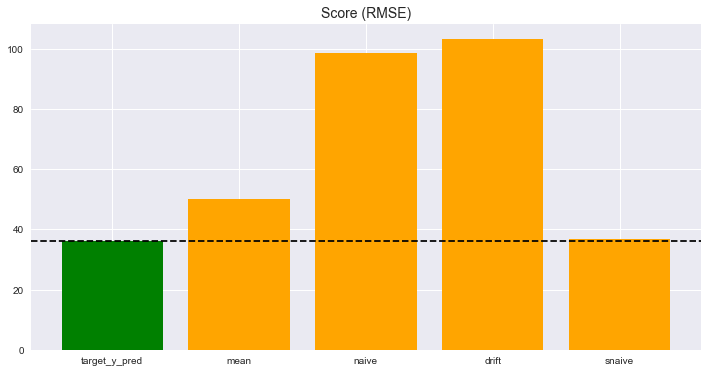

In [53]:
print(f"Full time of Search: {(t1 - t0):.2f} s")
print()

best_fasts_sc = rscv_sc.best_params_['best_estimator']

print("=== Compare best estimator to baselines on test data...")

scores_sc, spreds_sc, tgt_preds_sc = best_fasts_sc.compare_to_baselines(
    y_train_sc, 
    y_test_sc, 
    season=11,
    fh=fh, 
    bar_plot=True,
    bck_transformer=scaler
)

FASTS does slightly better than seasonal naive...

In [54]:
us.mean_absolute_percentage_error(
    sunspots_y.values[-fh:],
    tgt_preds_sc[tgt_preds_sc > 0].fillna(0)["y_pred"])

73.09236903634493

... but performs bad on test data.


full_time_series_df
            orig_scale_posts   forecasts      y_test       mean   naive  \
Month                                                                     
1979-12-31               NaN  128.761531  155.275000  49.439708  158.75   
1980-12-31               NaN  114.412020  154.650000  49.439708  158.75   
1981-12-31               NaN   84.921510  140.375000  49.439708  158.75   
1982-12-31               NaN   50.777389  116.291667  49.439708  158.75   
1983-12-31               NaN   23.824112   66.633333  49.439708  158.75   

                 drift      snaive     low_80       up_80  low_95       up_95  
Month                                                                          
1979-12-31  167.911778  189.850000  34.459556  223.063506     0.0  273.161430  
1980-12-31  168.333667  184.591667  22.360111  206.463929     0.0  255.366505  
1981-12-31  168.966500  158.750000   0.000000  181.543166     0.0  232.873420  
1982-12-31  169.388389  135.116667   0.000000  149.02

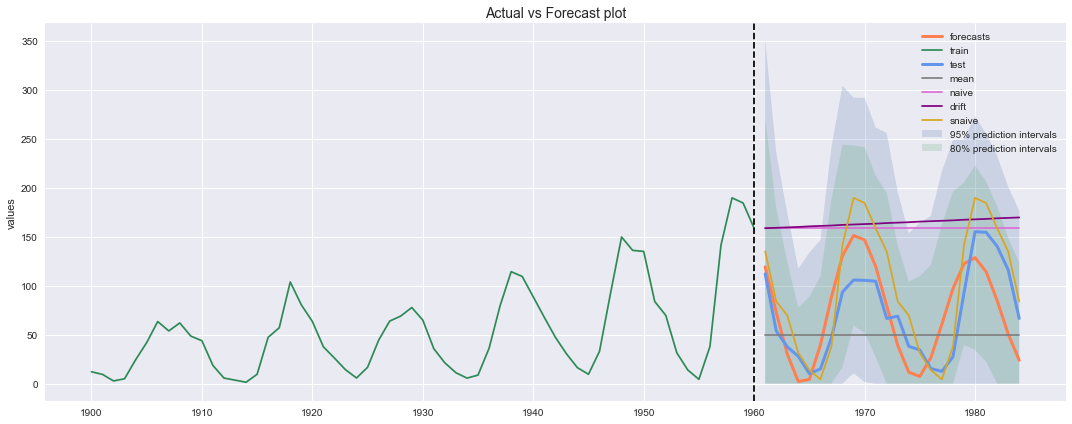

In [55]:
us.plot_forecasts(
    sunspots_y["Sunspots"][150:-fh],
    tgt_preds_sc[tgt_preds_sc > 0].fillna(0),
    sunspots_y.index[150:], 
    y_test=sunspots_y["Sunspots"][-fh:],
    simple_preds=spreds_sc,
    return_pred_int=True)

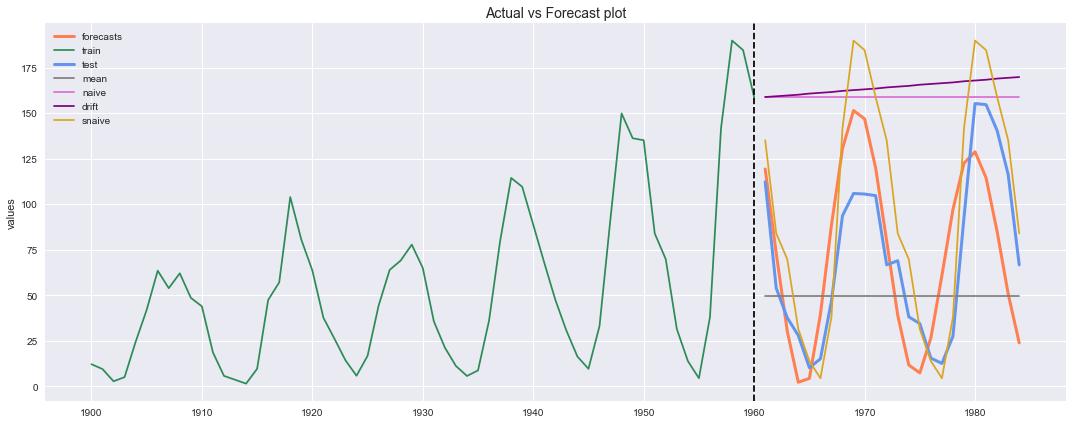

In [56]:
us.plot_forecasts(
    sunspots_y["Sunspots"][150:-fh],
    tgt_preds_sc[tgt_preds_sc > 0].fillna(0),
    sunspots_y.index[150:], 
    y_test=sunspots_y["Sunspots"][-fh:],
    simple_preds=spreds_sc)

Model with scaled data is **unable** to match both peaks and next solar cycles. Differentiation may help.